# 自编码器-XGBOOST-聚类-对比可视化分析

## 准备模块
- NumPy：
提供多维数组对象和各种计算工具，是许多其他 Python 数据科学库的基础，支持大量的维度数组与矩阵运算


- pandas：
提供高效、灵活的数据结构（如DataFrame），支持数据清洗、处理、分析等操作，是数据预处理和分析的核心工具


- scikit-learn：
强大的机器学习库，提供分类、回归、聚类等算法，包含各种模型评估指标和工具，提供数据预处理和特征工程功能


- TensorFlow：
开源的深度学习框架，支持构建和训练各种神经网络模型，可用于图像识别、自然语言处理等多个领域


- XGBoost：
高性能的梯度提升库，在Kaggle等数据科学竞赛中经常使用，支持并行计算，速度快且性能优秀

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

### 相关辅助设置
进行辅助设置完成可视化等功能的相关操作

In [3]:
# 设置Matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用SimHei字体支持中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [4]:
# 类别名称
class_names = ['T恤', '裤子', '套衫', '连衣裙', '外套', '凉鞋', '衬衫', '运动鞋', '包', '踝靴']

## 一、加载数据
读取CSV文件，加载所提供的数据集的训练集和测试集，进行数据拆分为图像特征和标签

In [5]:
def load_data(train, test):
    # 读取训练集
    train_labels = train.iloc[:, 0].values.astype(np.uint8)
    train_images = train.iloc[:, 1:].values.astype(np.uint8)

    # 读取测试集 
    test_labels = test.iloc[:, 0].values.astype(np.uint8)
    test_images = test.iloc[:, 1:].values.astype(np.uint8)

    return (train_images, train_labels), (test_images, test_labels)

In [6]:
# 加载数据
train = pd.read_csv("./dataset/fashion-mnist_train.csv")
test = pd.read_csv("./dataset/fashion-mnist_test.csv") 
(train_images, train_labels), (test_images, test_labels) = load_data(train,test)
print("训练图像形状:", train_images.shape)
print("训练标签形状:", train_labels.shape)
print("测试图像形状:", test_images.shape)
print("测试标签形状:", test_labels.shape)

训练图像形状: (60000, 784)
训练标签形状: (60000,)
测试图像形状: (10000, 784)
测试标签形状: (10000,)


In [7]:
# 像素值归一化处理
train_images = train_images / 255.0 
test_images = test_images / 255.0

- 下面这段代码的作用是为去噪自编码器准备带噪声的训练数据，通过添加高斯噪声迫使模型学习数据的本质特征，提升模型的鲁棒性和泛化能力。

In [8]:
# 添加去噪自编码器的高斯噪声
noise_factor = 0.1
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

In [9]:
# 将数据最终变为展开形式，在此模型中数据已经是展开过，所以无变化
x_train_flat = train_images_noisy
x_test_flat = test_images_noisy
print(f"展平后训练数据形状: {x_train_flat.shape}")
print(f"展平后测试数据形状: {x_test_flat.shape}")

展平后训练数据形状: (60000, 784)
展平后测试数据形状: (10000, 784)


## 二、自编码器模型

1.深度自编码器由编码器和解码器组成。编码器将输入图像转换为潜在空间的表示，解码器则以该潜在向量作为输入，尝试重建原始图像。


2.深度自编码器通过最小化重建图像与原始图像之间的差异来训练模型。

### 1.构建自编码器模型
- 在自编码器模型中，latent_dim 代表潜在空间的维度，也就是编码器最终输出的特征向量的维度，它决定了模型对输入数据进行压缩后的表示维度，便于提取关键信息。


- 较小的latent_dim 可以实现更高度的压缩，但可能会损失一些信息；较大的 latent_dim 则保留更多信息，但压缩效果可能不那么显著。


- 在最后一层潜在向量输出层当中，latent_dim（值为64）是之前定义的潜在空间维度，表示该层的神经元数量。

In [10]:
# 构建自编码器
original_dim = x_train_flat.shape[1]
latent_dim = 64

# 编码器
#第一层
input_img = Input(shape=(original_dim,), name="encoder_input")
encoded = Dense(1024, name="encoder_dense_1")(input_img)
encoded = BatchNormalization()(encoded)
encoded = Activation('relu')(encoded)
encoded = Dropout(0.3)(encoded)

#第二层
encoded = Dense(512, name="encoder_dense_2")(encoded)
encoded = BatchNormalization()(encoded)
encoded = Activation('relu')(encoded)
encoded = Dropout(0.3)(encoded)

#第三层（隐藏层）
encoded = Dense(256, name="encoder_dense_3")(encoded)
encoded = BatchNormalization()(encoded)
encoded = Activation('relu')(encoded)
latent_vector = Dense(latent_dim, activation='relu', name="bottleneck")(encoded)

### 2.构建解码器，实现图像重建 

In [14]:
# 解码器
decoded = Dense(256, name="decoder_dense_1")(latent_vector)
decoded = BatchNormalization()(decoded)
decoded = Activation('relu')(decoded)
decoded = Dropout(0.2)(decoded)

decoded = Dense(512, name="decoder_dense_2")(decoded)
decoded = BatchNormalization()(decoded)
decoded = Activation('relu')(decoded)
decoded = Dropout(0.2)(decoded)

decoded = Dense(1024, name="decoder_dense_3")(decoded)
decoded = BatchNormalization()(decoded)
decoded = Activation('relu')(decoded)
reconstructed_img = Dense(original_dim, activation='sigmoid', name="decoder_output")(decoded)

### 3.自编码器结构摘要信息图
- Layer (type)：表示模型中各层的名称及类型，比如encoder_input(InputLayer) 说明这是编码器的输入层，类型为InputLayer；encoder_dense_1表示编码器的第一个全连接层。


- Output Shape：展示经过该层处理后数据的输出形状。其中None表示这一维的大小在运行时可以根据输入数据的实际情况动态确定，比如 (None, 784) 表示样本数量维度可变，特征维度为784。


- Param #：指该层的参数数量。对于全连接层等含有权重参数的层，此数值反映了该层权重和偏置等参数的总数；对于像 Activation、Dropout等无参数层，该数值为0。

In [12]:
# 自编码器和解码器模型
autoencoder = Model(input_img, reconstructed_img, name="autoencoder")
autoencoder.summary()
encoder = Model(input_img, latent_vector, name="encoder")
encoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_1 (Dense)              │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_2 (Dense)              │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_3 (Dense)              │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (Dense)                   │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense_1 (Dense)              │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense_2 (Dense)              │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,967,888 (11.32 MB)

 Trainable params: 2,960,720 (11.29 MB)

 Non-trainable params: 7,168 (28.00 KB)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_1 (Dense)              │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_2 (Dense)              │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_3 (Dense)              │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (Dense)                   │ (None, 64)                  │          16,448 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,483,584 (5.66 MB)

 Trainable params: 1,480,000 (5.65 MB)

 Non-trainable params: 3,584 (14.00 KB)

### 4.自编码器训练过程
1.模型编译：使用 Adam 优化器和均方误差 (MSE) 损失函数配置自编码器。

2.早停策略配置：
- 监控指标：验证集损失 (val_loss)


- 耐心值：10 个轮次 (epochs)


- 权重恢复：自动保存并恢复验证损失最低时的模型权重

3.训练结果：
训练历史保存在history对象中，可用于后续可视化分析
早停机制可能在 100 轮前提前终止训练，避免过拟合


In [13]:
# 编译和训练自编码器（添加早停策略）
from tensorflow.keras.callbacks import EarlyStopping

autoencoder.compile(optimizer='adam', loss='mse')
print("\n训练自编码器...")

# 定义早停回调
early_stopping = EarlyStopping(
    monitor='val_loss',       # 监控验证损失
    patience=10,              # 10个epoch内损失未改善则停止
    restore_best_weights=True, # 恢复最佳权重
    verbose=1                 # 显示早停信息
)

history = autoencoder.fit(
    x_train_flat, x_train_flat,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_flat, x_test_flat),
    callbacks=[early_stopping],  # 添加早停回调
    verbose=1
)


训练自编码器...
Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 0.0471 - val_loss: 0.0279
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0255 - val_loss: 0.0242
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.0235 - val_loss: 0.0214
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 0.0223 - val_loss: 0.0202
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0215 - val_loss: 0.0196
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 0.0210 - val_loss: 0.0187
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 0.0205 - val_loss: 0.0182
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 0.0200 - val_loss: 0.0180
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 0.0198 - val_loss: 0.0180
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.0196 - val_loss: 0.0175
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 0.0193 - val_loss: 0.0173
Epoch 12

235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 68/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 69/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 70/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0161 - val_loss: 0.0146
Epoch 71/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0161 - val_loss: 0.0147
Epoch 72/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0161 - val_loss: 0.0145
Epoch 73/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.0161 - val_loss: 0.0146
Epoch 74/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0161 - val_loss: 0.0145
Epoch 75/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0160 - val_loss: 0.0147
Epoch 76/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 0.0160 - val_loss: 0.0145
Epoch 77/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0161 - val_loss: 0.0145
Epoch 78/100
235/235 ━━

### 5.损失曲线绘制，提取特征
#### 损失曲线绘制

- 训练损失：衡量模型在训练数据上的表现，目标是尽可能低。


- 验证损失：衡量模型在未见过数据上的表现，反映泛化能力，是评估模型质量的关键。



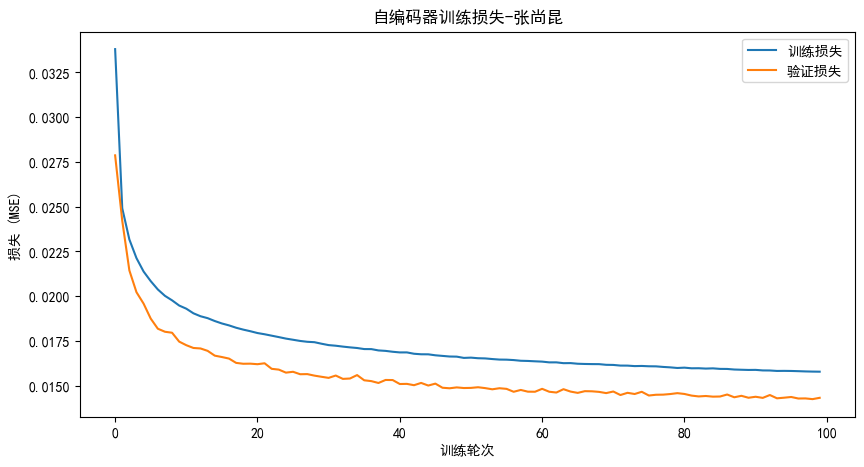

In [15]:
# 绘制训练损失曲线
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('自编码器训练损失-张尚昆')
plt.xlabel('训练轮次')
plt.ylabel('损失 (MSE)')
plt.legend()
plt.show()

#### 提取潜在特征
1.数据输入：x_train_flat和x_test_flat代表的是经过展平处理后的训练数据和测试数据。

2.模型预测：调用encoder.predict()方法，让编码器对输入数据进行转换，从而得到潜在空间中的特征表示。

3.结果输出：输出的潜在特征形状通常为(样本数量, 潜在维度)。

通过监控两者，可以优化训练过程（如调整轮次、模型结构）以提升性能。

In [16]:
# 提取潜在特征
latent_features_train = encoder.predict(x_train_flat)
latent_features_test = encoder.predict(x_test_flat)
print(f"训练集潜在特征形状: {latent_features_train.shape}")
print(f"测试集潜在特征形状: {latent_features_test.shape}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
训练集潜在特征形状: (60000, 64)
测试集潜在特征形状: (10000, 64)


## 三、构建XGBoost分类器

XGBoost（Extreme Gradient Boosting）分类器是一种高效、强大的机器学习算法，广泛用于分类任务。

1. XGBoost定义：
XGBoost 是一种基于梯度提升树的算法，通过组合多个弱学习器（通常是决策树）来构建一个强学习器。它在分类任务中预测离散类别，通过优化损失函数（如多类对数损失 mlogloss）来提高预测准确率。


2. 核心特点：


- 梯度提升：XGBoost 按顺序训练决策树，每棵树纠正前一棵树的错误，逐步提升模型性能。


- 正则化：支持 L1（reg_alpha）和 L2（reg_lambda）正则化，防止过拟合，提高泛化能力。


- 高效性：通过并行计算、树剪枝和稀疏数据处理，XGBoost 训练速度快，适合大数据集。


- 灵活性：支持多种损失函数（如 mlogloss 用于多分类），可自定义评估指标。

###  1.XGBoost分类器

In [17]:
# XGBoost分类器
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 准备训练数据：将原始特征数据划分为训练集和验证集
# 验证集用于在训练过程中监控模型性能，防止过拟合
train_features, val_features, train_labels_split, val_labels = train_test_split(
    latent_features_train,      # 原始训练特征
    train_labels,               # 原始训练标签
    test_size=0.2,              # 划分20%的数据作为验证集
    random_state=42             # 固定随机种子，确保结果可复现
)

print("\n开始训练XGBoost分类器...")

# 初始化XGBoost分类器，设置模型参数
xgb = XGBClassifier(
    n_estimators=600,           # 树的数量，控制模型复杂度
    max_depth=8,                # 每棵树的最大深度，防止过拟合
    learning_rate=0.05,         # 学习率，较小的值通常需要更多树
    subsample=0.7,              # 训练样本的采样比例，降低过拟合风险
    colsample_bytree=0.7,       # 每棵树使用特征的比例，增加随机性
    gamma=0.1,                  # 分裂所需的最小损失减少，控制树的生长
    reg_lambda=1.5,             # L2正则化系数，减少模型复杂度
    n_jobs=-1,                  # 使用所有CPU核心并行训练
    random_state=42,            # 固定随机种子
    eval_metric='mlogloss'      # 多分类问题的评估指标：多类对数损失
)

# 定义评估数据集，用于在训练过程中监控模型性能
eval_set = [
    (train_features, train_labels_split),  # 训练集评估数据
    (val_features, val_labels)             # 验证集评估数据
]

# 训练XGBoost模型
xgb.fit(
    X=train_features,               # 训练特征
    y=train_labels_split,           # 训练标签
    eval_set=eval_set,              # 指定评估数据集
    verbose=True                    # 每轮迭代打印评估结果
)

# 使用训练好的模型对测试集进行预测
xgb_predictions = xgb.predict(latent_features_test)

# 计算并打印模型在测试集上的准确率
xgb_accuracy = accuracy_score(test_labels, xgb_predictions)
print(f"XGBoost分类器在测试集上的准确率: {xgb_accuracy * 100:.2f}%")


开始训练XGBoost分类器...
[0]	validation_0-mlogloss:2.15395	validation_1-mlogloss:2.16362
[1]	validation_0-mlogloss:2.02782	validation_1-mlogloss:2.04652
[2]	validation_0-mlogloss:1.91728	validation_1-mlogloss:1.94372
[3]	validation_0-mlogloss:1.81867	validation_1-mlogloss:1.85236
[4]	validation_0-mlogloss:1.73297	validation_1-mlogloss:1.77249
[5]	validation_0-mlogloss:1.65432	validation_1-mlogloss:1.69938
[6]	validation_0-mlogloss:1.58213	validation_1-mlogloss:1.63223
[7]	validation_0-mlogloss:1.51456	validation_1-mlogloss:1.56971
[8]	validation_0-mlogloss:1.45383	validation_1-mlogloss:1.51328
[9]	validation_0-mlogloss:1.39767	validation_1-mlogloss:1.46184
[10]	validation_0-mlogloss:1.34577	validation_1-mlogloss:1.41431
[11]	validation_0-mlogloss:1.29695	validation_1-mlogloss:1.36911
[12]	validation_0-mlogloss:1.25037	validation_1-mlogloss:1.32604
[13]	validation_0-mlogloss:1.20763	validation_1-mlogloss:1.28676
[14]	validation_0-mlogloss:1.16681	validation_1-mlogloss:1.24941
[15]	validation_

[126]	validation_0-mlogloss:0.20336	validation_1-mlogloss:0.40156
[127]	validation_0-mlogloss:0.20164	validation_1-mlogloss:0.40053
[128]	validation_0-mlogloss:0.19997	validation_1-mlogloss:0.39956
[129]	validation_0-mlogloss:0.19859	validation_1-mlogloss:0.39867
[130]	validation_0-mlogloss:0.19706	validation_1-mlogloss:0.39772
[131]	validation_0-mlogloss:0.19558	validation_1-mlogloss:0.39683
[132]	validation_0-mlogloss:0.19409	validation_1-mlogloss:0.39594
[133]	validation_0-mlogloss:0.19279	validation_1-mlogloss:0.39508
[134]	validation_0-mlogloss:0.19125	validation_1-mlogloss:0.39418
[135]	validation_0-mlogloss:0.18990	validation_1-mlogloss:0.39329
[136]	validation_0-mlogloss:0.18851	validation_1-mlogloss:0.39257
[137]	validation_0-mlogloss:0.18709	validation_1-mlogloss:0.39179
[138]	validation_0-mlogloss:0.18570	validation_1-mlogloss:0.39105
[139]	validation_0-mlogloss:0.18421	validation_1-mlogloss:0.39030
[140]	validation_0-mlogloss:0.18300	validation_1-mlogloss:0.38963
[141]	vali

[251]	validation_0-mlogloss:0.08639	validation_1-mlogloss:0.35086
[252]	validation_0-mlogloss:0.08595	validation_1-mlogloss:0.35072
[253]	validation_0-mlogloss:0.08525	validation_1-mlogloss:0.35048
[254]	validation_0-mlogloss:0.08482	validation_1-mlogloss:0.35032
[255]	validation_0-mlogloss:0.08422	validation_1-mlogloss:0.35015
[256]	validation_0-mlogloss:0.08370	validation_1-mlogloss:0.34999
[257]	validation_0-mlogloss:0.08319	validation_1-mlogloss:0.34991
[258]	validation_0-mlogloss:0.08277	validation_1-mlogloss:0.34974
[259]	validation_0-mlogloss:0.08228	validation_1-mlogloss:0.34958
[260]	validation_0-mlogloss:0.08181	validation_1-mlogloss:0.34950
[261]	validation_0-mlogloss:0.08135	validation_1-mlogloss:0.34939
[262]	validation_0-mlogloss:0.08083	validation_1-mlogloss:0.34925
[263]	validation_0-mlogloss:0.08032	validation_1-mlogloss:0.34914
[264]	validation_0-mlogloss:0.07982	validation_1-mlogloss:0.34900
[265]	validation_0-mlogloss:0.07928	validation_1-mlogloss:0.34889
[266]	vali

[376]	validation_0-mlogloss:0.04286	validation_1-mlogloss:0.34169
[377]	validation_0-mlogloss:0.04266	validation_1-mlogloss:0.34163
[378]	validation_0-mlogloss:0.04242	validation_1-mlogloss:0.34160
[379]	validation_0-mlogloss:0.04220	validation_1-mlogloss:0.34161
[380]	validation_0-mlogloss:0.04204	validation_1-mlogloss:0.34158
[381]	validation_0-mlogloss:0.04187	validation_1-mlogloss:0.34158
[382]	validation_0-mlogloss:0.04164	validation_1-mlogloss:0.34152
[383]	validation_0-mlogloss:0.04146	validation_1-mlogloss:0.34148
[384]	validation_0-mlogloss:0.04128	validation_1-mlogloss:0.34152
[385]	validation_0-mlogloss:0.04105	validation_1-mlogloss:0.34147
[386]	validation_0-mlogloss:0.04090	validation_1-mlogloss:0.34145
[387]	validation_0-mlogloss:0.04071	validation_1-mlogloss:0.34145
[388]	validation_0-mlogloss:0.04047	validation_1-mlogloss:0.34147
[389]	validation_0-mlogloss:0.04027	validation_1-mlogloss:0.34145
[390]	validation_0-mlogloss:0.04003	validation_1-mlogloss:0.34148
[391]	vali

[501]	validation_0-mlogloss:0.02496	validation_1-mlogloss:0.34315
[502]	validation_0-mlogloss:0.02486	validation_1-mlogloss:0.34314
[503]	validation_0-mlogloss:0.02476	validation_1-mlogloss:0.34319
[504]	validation_0-mlogloss:0.02466	validation_1-mlogloss:0.34320
[505]	validation_0-mlogloss:0.02457	validation_1-mlogloss:0.34329
[506]	validation_0-mlogloss:0.02448	validation_1-mlogloss:0.34328
[507]	validation_0-mlogloss:0.02441	validation_1-mlogloss:0.34332
[508]	validation_0-mlogloss:0.02433	validation_1-mlogloss:0.34338
[509]	validation_0-mlogloss:0.02424	validation_1-mlogloss:0.34339
[510]	validation_0-mlogloss:0.02417	validation_1-mlogloss:0.34340
[511]	validation_0-mlogloss:0.02407	validation_1-mlogloss:0.34346
[512]	validation_0-mlogloss:0.02397	validation_1-mlogloss:0.34349
[513]	validation_0-mlogloss:0.02389	validation_1-mlogloss:0.34347
[514]	validation_0-mlogloss:0.02381	validation_1-mlogloss:0.34347
[515]	validation_0-mlogloss:0.02373	validation_1-mlogloss:0.34349
[516]	vali

#### 训练过程输出：
- 每行代表一轮迭代（共 500 轮）


- train-mlogloss：训练集上的多类对数损失，随迭代减少


- val-mlogloss：验证集上的多类对数损失，用于监控过拟合

### 2.保存XGBoost预测结果

In [18]:
# 保存XGBoost预测结果到CSV
evaluation_results = {
    '真实标签': test_labels,
    '预测标签': xgb_predictions,
    '是否正确': ['True' if true == pred else 'False' for true, pred in zip(test_labels, xgb_predictions)]
}
test_df = pd.DataFrame(evaluation_results)
test_df.to_csv('./XGBoost_results.csv', index=False, encoding='utf-8-sig')
print(f"\nXGBoost预测结果已保存至 ./XGBoost_results.csv")


XGBoost预测结果已保存至 ./XGBoost_results.csv


在这里将XGBoost预测结果进行保存，便于更加直观的对分类的效果进行评估

## 四.在潜在特征上执行K-Means聚类

### 1.K-Means聚类
#### 1.基本概念： 
- 簇与质心：“簇” 是数据点的集合，同一簇内的数据点彼此之间比与其他簇的数据点更相似。“质心” 是簇内所有点的平均位置，代表了簇的中心。算法的目标是使每个数据点都属于离它最近的簇中心（质心），从而使簇内的方差最小。


- 距离度量：通常使用欧氏距离（简单理解就是两点间直线距离，在多维空间有规范定义 ）来衡量数据点与质心的距离，即认为两个对象的距离越近，其相似度就越大。

#### 2.算法步骤：
- 随机初始化质心：随机选取K个点作为初始的聚类中心（质心）。初始质心的选择可能会极大影响算法的收敛速度和最终聚类的质量，不恰当的初始质心可能导致簇结果不稳定或收敛到局部最优。


- 分配数据点到簇：计算每个数据点到各个质心的距离，把每个数据点分配给距离它最近的质心，形成K个簇。


- 更新质心：对于每个簇，重新计算其质心，通常是计算簇内所有数据点的均值。 判断收敛：重复步骤2和3，不断迭代，直到满足某个终止条件。终止条件可以是没有（或最小数目）对象被重新分配给不同的聚类；没有（或最小数目）聚类中心再发生变化；误差平方和局部最小等。

#### 3.目标函数：
- 目标函数 K-Means 算法基于给定的聚类目标函数，采用迭代更新的方法，每一次迭代过程都是向目标函数减小的方向进行，最终聚类结果使得目标函数取得极小值，达到较好的分类效果。常用的目标函数是簇内误差平方和（SSE），计算方法是将簇内每个点到其质心的距离平方求和。优化目标就是最小化SSE，从而提高簇的紧密性

In [19]:
# --- K-Means聚类 ---
num_clusters = 10
print(f"\n在测试集潜在特征上执行K-Means聚类 (K={num_clusters})...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
cluster_assignments_test = kmeans.fit_predict(latent_features_test)


在测试集潜在特征上执行K-Means聚类 (K=10)...


### 2.计算多种聚类评估指标
- 1.利用 silhouette_score 计算轮廓系数，衡量样本与其所在簇内其他样本的相似程度，以及与其他簇样本的不相似程度，值越接近1表示聚类效果越好。


- 2通过 adjusted_rand_score 算出调整兰德指数，评估两个聚类结果的相似性，取值范围[-1, 1]，值越大聚类结果一致性越高。


- 3.借助 normalized_mutual_info_score 得到归一化互信息，度量两个聚类结果共享的信息量，值越接近1表示两个聚类结构越相似。


- 4.运用 homogeneity_score 算出同质性得分，衡量一个簇中是否只包含单个类别的样本，值为1表示完美同质性。


- 5.用 completeness_score 计算完整性得分，考察同一类别的样本是否都被分配到同一个簇中，值为1表示完美完整性。


- 6.通过 v_measure_score 算出V-Measure 得分，是同质性和完整性的调和平均，综合评估聚类效果，值越接近1越好。


- 7自定义calculate_clustering_accuracy 函数：构建列联表（contingency_matrix），统计真实标签和聚类标签的对应关系。

In [20]:
# 多种评估指标
silhouette_avg_test = silhouette_score(latent_features_test, cluster_assignments_test)
ari_test = adjusted_rand_score(test_labels, cluster_assignments_test)
nmi_test = normalized_mutual_info_score(test_labels, cluster_assignments_test)
homogeneity = homogeneity_score(test_labels, cluster_assignments_test)
completeness = completeness_score(test_labels, cluster_assignments_test)
v_measure = v_measure_score(test_labels, cluster_assignments_test)

print(f"\n轮廓系数 (测试集): {silhouette_avg_test:.4f}")
print(f"调整兰德指数 (测试集): {ari_test:.4f}")
print(f"归一化互信息 (测试集): {nmi_test:.4f}")
print(f"同质性得分 (测试集): {homogeneity:.4f}")
print(f"完整性得分 (测试集): {completeness:.4f}")
print(f"V-Measure得分 (测试集): {v_measure:.4f}")


def calculate_clustering_accuracy(true_labels, cluster_labels, n_clusters):
    contingency_matrix = np.zeros((n_clusters, n_clusters), dtype=np.int64)
    for i in range(len(true_labels)):
        contingency_matrix[cluster_labels[i], true_labels[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    correct_predictions = contingency_matrix[row_ind, col_ind].sum()
    accuracy = correct_predictions / len(true_labels)
    return accuracy, row_ind, col_ind

clustering_accuracy_test, row_ind, col_ind = calculate_clustering_accuracy(test_labels, cluster_assignments_test, num_clusters)
print(f"聚类准确率 (测试集): {clustering_accuracy_test * 100:.2f}%")



轮廓系数 (测试集): 0.0806
调整兰德指数 (测试集): 0.3147
归一化互信息 (测试集): 0.4543
同质性得分 (测试集): 0.4442
完整性得分 (测试集): 0.4650
V-Measure得分 (测试集): 0.4543
聚类准确率 (测试集): 50.14%


- 通过上述的相关准确率计算就可得知，聚类的效果并不好

### 3.可视化聚类图像

In [21]:
# 映射聚类标签到真实标签
mapped_labels = np.zeros_like(cluster_assignments_test)
for cluster_idx, true_label in zip(row_ind, col_ind):
    mapped_labels[cluster_assignments_test == cluster_idx] = true_label

#### 可视化每个聚类示例图像
1.参数设定：
- n_examples_per_cluster = 5，即每个聚类会展示 5 个示例图像。


- 图像的大小由plt.figure(figsize=(num_clusters * 2, n_examples_per_cluster * 2))动态确定，确保布局合理。

2.聚类标签映射：
- 运用cluster_to_label字典，把聚类索引和对应的类别名称（像数字 0 - 9）建立映射关系。

3.图像选择与展示：
- 针对每个聚类，找出所有被分配到该聚类的测试样本索引。


- 随机选取不超过n_examples_per_cluster数量的样本。


- 采用n_examples_per_cluster行、num_clusters列的网格布局展示图像。

4.图像格式处理：
-  把展平的图像数据（784 维）重新调整为 28×28 的图像矩阵。

- 关闭坐标轴显示，使图像更加简洁。

5.图像优化：
- 使用plt.tight_layout(rect=[0, 0, 1, 0.96])对布局进行优化，为总标题留出空间。


可视化每个聚类的示例图像...


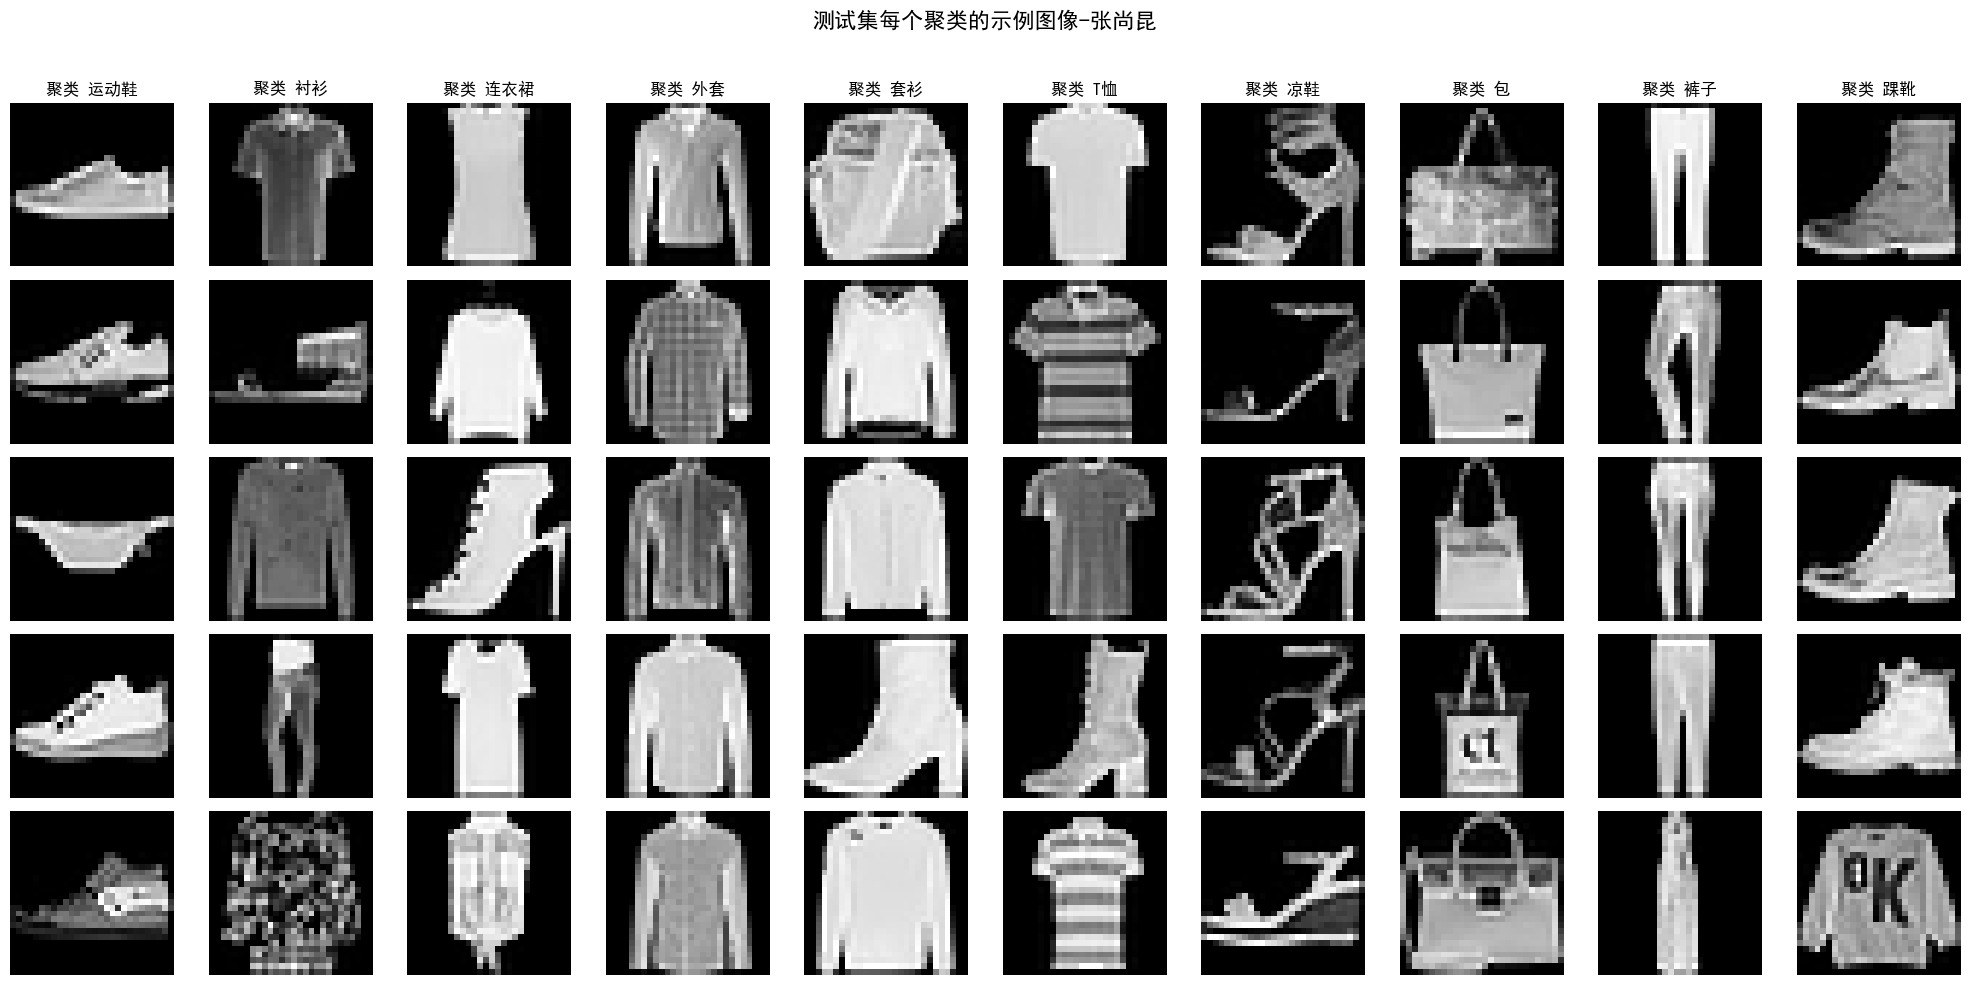

In [22]:
# 可视化每个聚类的示例图像
print("\n可视化每个聚类的示例图像...")
n_examples_per_cluster = 5
plt.figure(figsize=(num_clusters * 2, n_examples_per_cluster * 2))
cluster_to_label = {cluster_idx: class_names[true_label] for cluster_idx, true_label in zip(row_ind, col_ind)}
for cluster_id in range(num_clusters):
    cluster_indices = np.where(cluster_assignments_test == cluster_id)[0]
    if len(cluster_indices) > 0:
        selected_indices = np.random.choice(cluster_indices, min(n_examples_per_cluster, len(cluster_indices)), replace=False)
        for i, img_idx in enumerate(selected_indices):
            ax = plt.subplot(n_examples_per_cluster, num_clusters, i * num_clusters + cluster_id + 1)
            plt.imshow(test_images[img_idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                ax.set_title(f"聚类 {cluster_to_label[cluster_id]}")
plt.suptitle("测试集每个聚类的示例图像-张尚昆", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- 可以看到，上面的每组类别中的五张照片并不是都属于这个类别，存在差异，所以聚类的效果并不好。

## 五.可视化分析

### 1.混淆矩阵的对比

- 混淆矩阵是机器学习中用于评估分类模型性能的经典工具，尤其适用于二分类和多分类问题。它通过统计分类模型的预测结果与真实标签的匹配情况，直观展示模型的 “混淆” 情况，帮助分析模型的优势和缺陷。

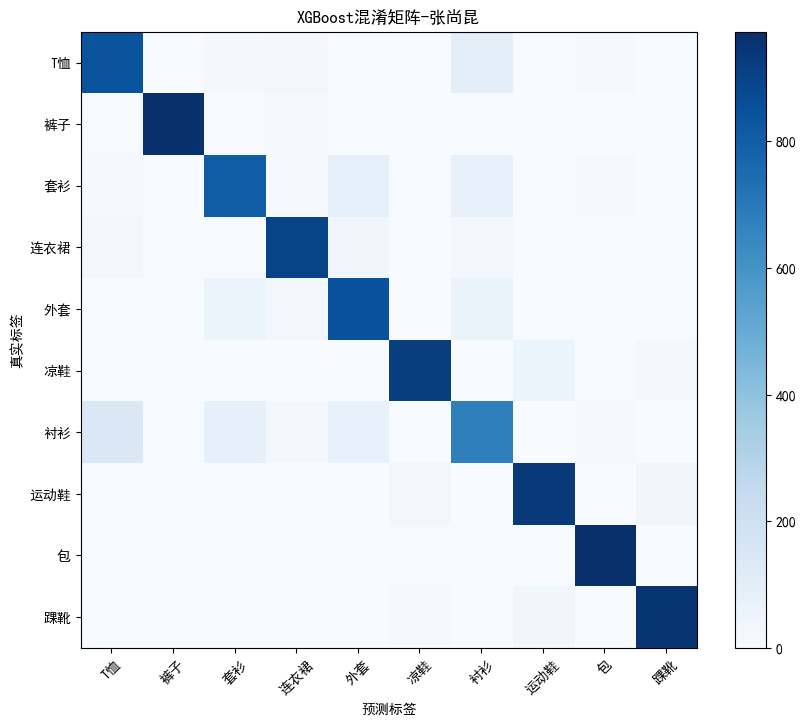

In [23]:
# XGBoost混淆矩阵可视化
cm_xgb = confusion_matrix(test_labels, xgb_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_xgb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('XGBoost混淆矩阵-张尚昆')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()


#### 这是 XGBoost 多分类模型的混淆矩阵，展示服饰品类分类预测结果，颜色越深对应数量越多。

##### 1.对角线分析

- 对角线上颜色深，说明 “T 恤”“裙子” 等多数品类模型能正确识别 ，有一定分类能力。

##### 2.非对角线分析

- 非对角线有颜色，像 “套衫”“衬衫”、“凉鞋”“运动鞋” 等相似品类存在误判，说明这些品类间因特征相似易混淆。


- 总的来说XGBoost的分类效果还是达到了较高的准确率

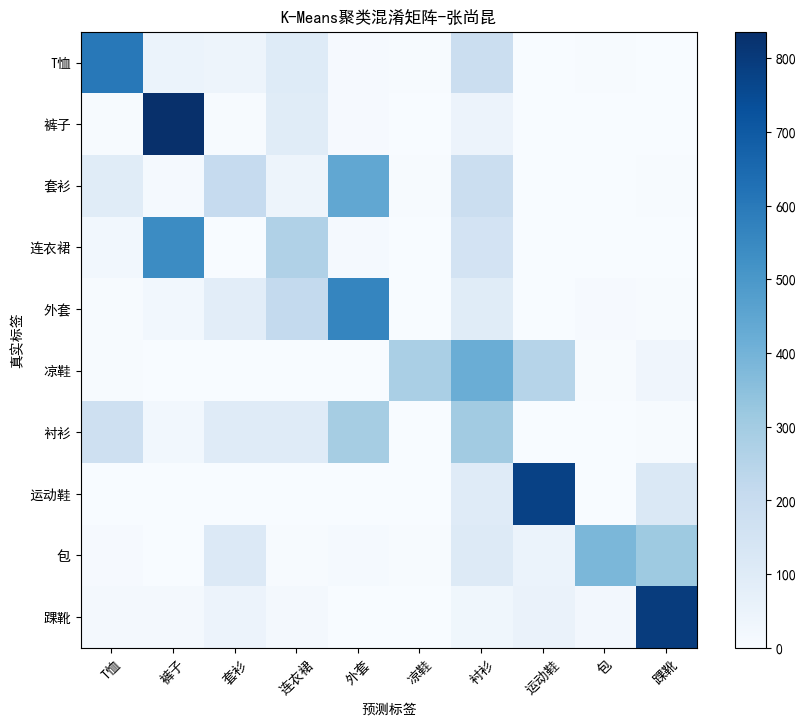

In [24]:
# 混淆矩阵可视化
cm = confusion_matrix(test_labels, mapped_labels)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('K-Means聚类混淆矩阵-张尚昆')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()

- 而在聚类产生的混淆矩阵中，各单元格颜色分布相对较为分散。在一些类别上，非对角线位置也有较深颜色，说明存在较多误判情况。例如，“套衫”“衬衫” 等类别，在非自身预测标签对应的列上，单元格颜色有一定深度，意味着这些类别容易被误判为其他类别，类别间混淆情况相对明显。

#### 对比XGBoost分析
- 1.XGBoost 混淆矩阵优势原因：XGBoost 是一种基于树的集成学习算法，属于有监督分类方法。通过迭代地训练多个弱分类器（树模型）来构建强分类器。它能自动进行特征选择和组合，利用正则化项（如L1、L2正则化）控制模型复杂度，防止过拟合。这使得它在处理复杂数据关系时，能更精准地捕捉各类别的特征，从而在混淆矩阵上体现为对角线颜色更深，正确预测数量更多。比如在识别 “T 恤”“裤子” 等类别时，能更准确区分，减少误判。


- 2.聚类混淆矩阵不足原因：聚类算法主要基于数据点之间的相似度进行划分，通常没有利用到类别标签的监督信息（无监督性质）。它可能无法很好地区分那些特征相近但属于不同类别的数据点。例如 “套衫” 和 “衬衫” 这类在特征上有相似性的类别，聚类算法难以精准区分，导致混淆矩阵中非对角线颜色较深，误判较多。而且聚类算法的结果受初始条件、距离度量方式等因素影响较大，稳定性可能不如 XGBoost 这类监督学习算法。

综上来说，出现这种情况是合理的

- 由此可以看出聚类方法得出的相关参数并不是很高，所以说聚类并不是特别适合这个问题的分类，但也可以将其拿来作为一项自编码器特征提取的可视化检验。


###  2.图像重建可视化

#### 借助 matplotlib 库，把测试集中的原始图像和自编码器重建的图像并排展示，以此直观地评估自编码器的性能。

- 1.参数设定：n_images_to_show = 10，这意味着会展示 10 组对比图像，能让人对整体的重建效果有一个初步的了解。预测重建图像：运用训练好的自编码器autoencoder对测试集x_test_flat开展预测，进而得到重建后的图像。


- 2.图像布局规划：
整个图像布局为 2 行 10 列，其中第一行展示原始图像，第二行展示对应的重建图像。
借助plt.subplot函数精准定位每个子图的位置。


- 3.图像显示与格式处理：
利用plt.imshow函数将展平的图像数据（784 维）重新还原成 28×28 的图像。
把色彩映射设置为'gray'，这符合 MNIST 数据集的灰度图像特性。
通过plt.axis('off')关闭坐标轴显示，让图像展示更加简洁。


- 4.保存与展示图像：
调用plt.show()在当前环境中显示图像。


可视化原始图像与重建图像...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


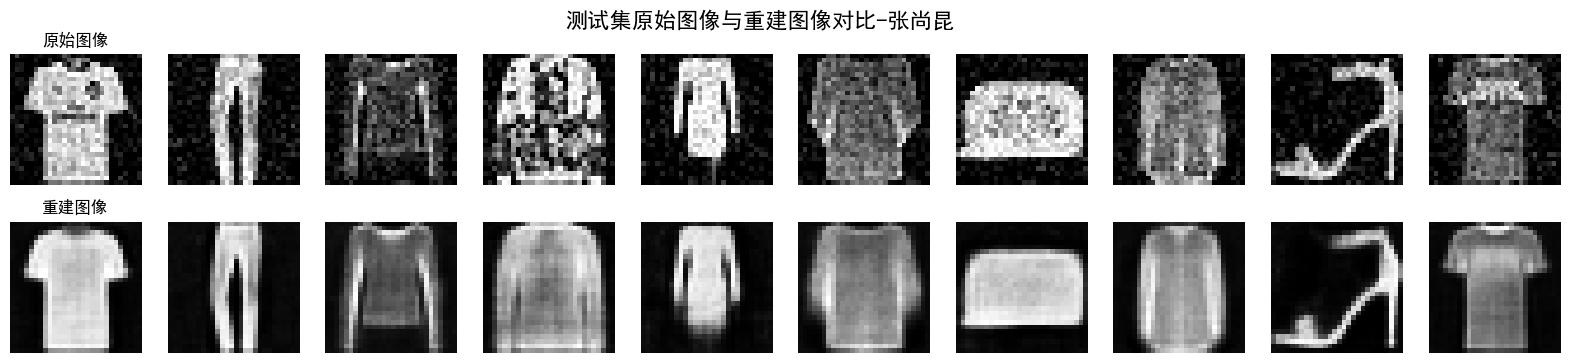

In [25]:
# 可视化原始图像与重建图像
print("\n可视化原始图像与重建图像...")
n_images_to_show = 10
reconstructed_test_imgs = autoencoder.predict(x_test_flat)
plt.figure(figsize=(20, 4))
for i in range(n_images_to_show):
    ax = plt.subplot(2, n_images_to_show, i + 1)
    plt.imshow(x_test_flat[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title("原始图像")
    ax = plt.subplot(2, n_images_to_show, i + 1 + n_images_to_show)
    plt.imshow(reconstructed_test_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title("重建图像")
plt.suptitle("测试集原始图像与重建图像对比-张尚昆", fontsize=16)
plt.show()

- 通过对比，发现图像在一定程度上完成了原始图像的重建

### 3.对比t-SNE 降维结果

- 下面这部分代码使用 t-SNE 算法将高维潜在空间特征降维到二维平面，以便可视化XGBoost分类，聚类结果，并于真实标签进行对比。为避免计算资源消耗过大，测试集样本量超过5000时会进行随机采样。t-SNE 降维后得到的二维坐标可用于绘制散点图，直观展示样本在聚类结果中的分布情况，帮助评估聚类质量。


t-SNE 算法的主要作用是把高维数据映射到二维平面上，从而实现数据的可视化。这里设置了以下参数：

- n_components=2：将数据降到二维空间，方便在平面上进行可视化展示。


- random_state=42：固定随机种子，确保每次运行代码时得到的降维结果都是一样的，保证结果的可复现性。


- perplexity=30：这个参数与每个点的邻居数量有关，通常取值在5到50之间。它对可视化的局部结构和全局结构的平衡有着重要影响。


-  n_iter=300：设置最大迭代次数，算法会在达到这个迭代次数后停止。

D:\anaconda\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


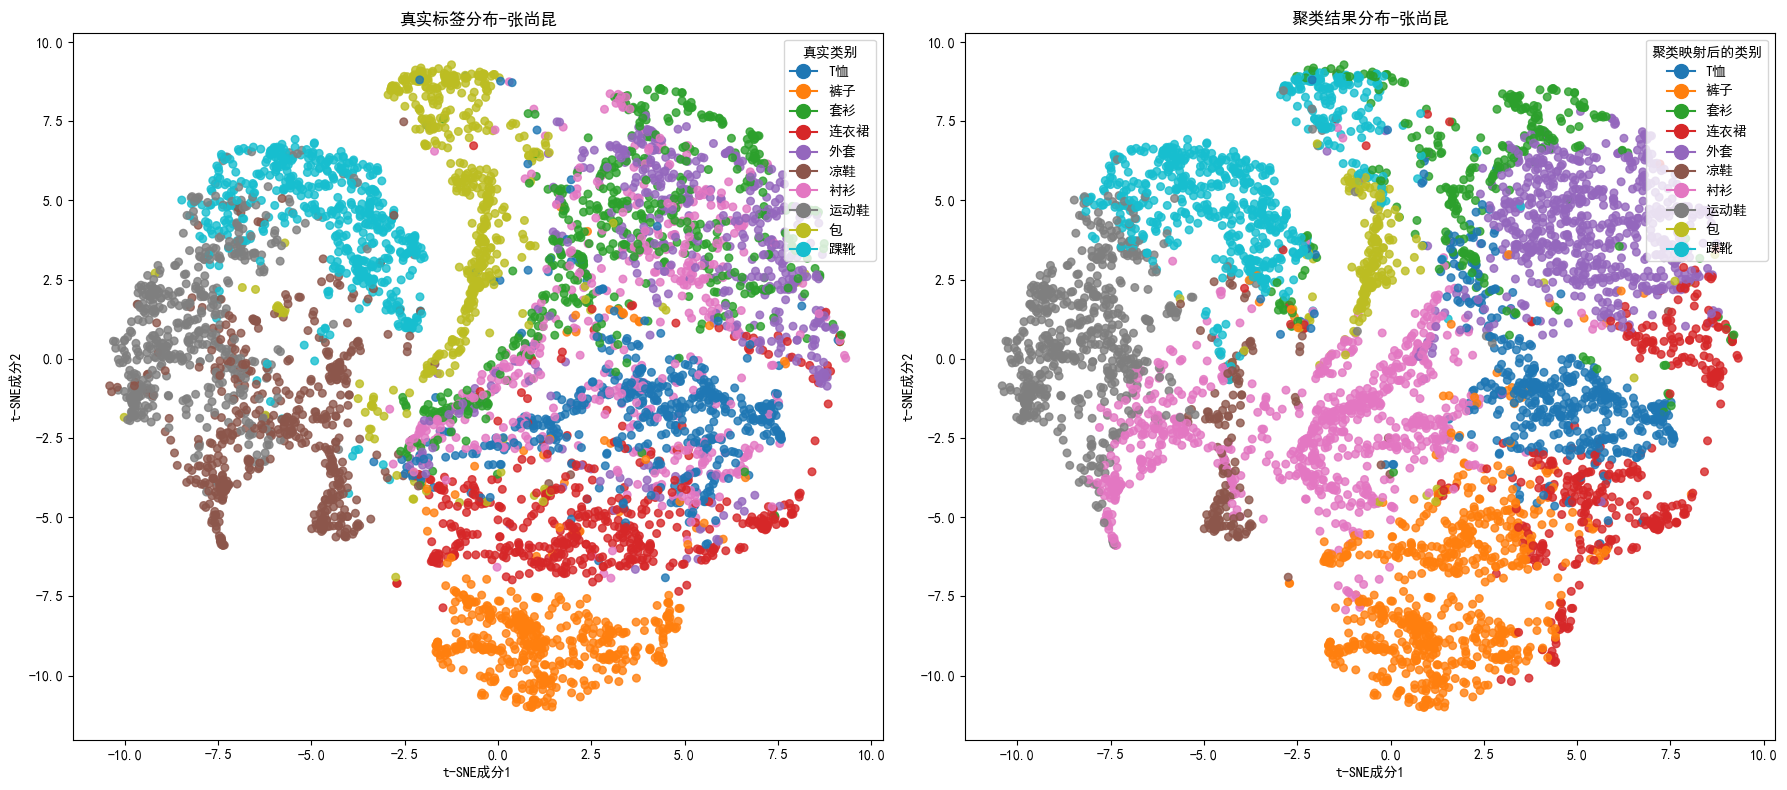

In [26]:
#t-SNE聚类可视化部分
tsne_subset_size = 5000
if len(latent_features_test) > tsne_subset_size:
    indices = np.random.choice(len(latent_features_test), tsne_subset_size, replace=False)
    tsne_features = latent_features_test[indices]
    tsne_clusters = cluster_assignments_test[indices]  # 聚类标签子集
    tsne_true_labels = test_labels[indices]  # 真实标签子集
else:
    tsne_features = latent_features_test
    tsne_clusters = cluster_assignments_test
    tsne_true_labels = test_labels

# 初始化t-SNE并降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
latent_2d_tsne = tsne.fit_transform(tsne_features)


# 聚类结果与真实标签的对比可视化
plt.figure(figsize=(18, 8))

# 子图1：按真实标签着色
plt.subplot(1, 2, 1)
scatter_true = plt.scatter(
    latent_2d_tsne[:, 0], 
    latent_2d_tsne[:, 1], 
    c=tsne_true_labels, 
    cmap='tab10', 
    s=30, 
    alpha=0.8
)
plt.title('真实标签分布-张尚昆')
plt.xlabel('t-SNE成分1')
plt.ylabel('t-SNE成分2')

# 手动创建图例（映射10个类别名称）
legend_elements = [
    plt.Line2D(
        [0], [0], 
        marker='o', 
        color=f'C{i}', 
        label=class_names[i], 
        markerfacecolor=f'C{i}', 
        markersize=10
    ) for i in range(10)
]
plt.legend(
    handles=legend_elements, 
    title="真实类别", 
    loc='upper right',  # 图例位置
    bbox_to_anchor=(1, 1)  # 调整图例与图像的间距
)


# 子图2：按聚类标签（映射后的真实标签）着色
plt.subplot(1, 2, 2)
# 先将聚类标签映射为真实标签（使用之前计算的row_ind和col_ind）
mapped_tsne_clusters = np.zeros_like(tsne_clusters)
for cluster_idx, true_label in zip(row_ind, col_ind):
    mapped_tsne_clusters[tsne_clusters == cluster_idx] = true_label

scatter_cluster = plt.scatter(
    latent_2d_tsne[:, 0], 
    latent_2d_tsne[:, 1], 
    c=mapped_tsne_clusters, 
    cmap='tab10', 
    s=30, 
    alpha=0.8
)
plt.title('聚类结果分布-张尚昆')
plt.xlabel('t-SNE成分1')
plt.ylabel('t-SNE成分2')

# 手动创建图例（与真实标签一致的类别名称）
legend_elements = [
    plt.Line2D(
        [0], [0], 
        marker='o', 
        color=f'C{i}', 
        label=class_names[i], 
        markerfacecolor=f'C{i}', 
        markersize=10
    ) for i in range(10)
]
plt.legend(
    handles=legend_elements, 
    title="聚类映射后的类别", 
    loc='upper right', 
    bbox_to_anchor=(1, 1)
)


plt.tight_layout()  # 自动调整子图间距
plt.show()

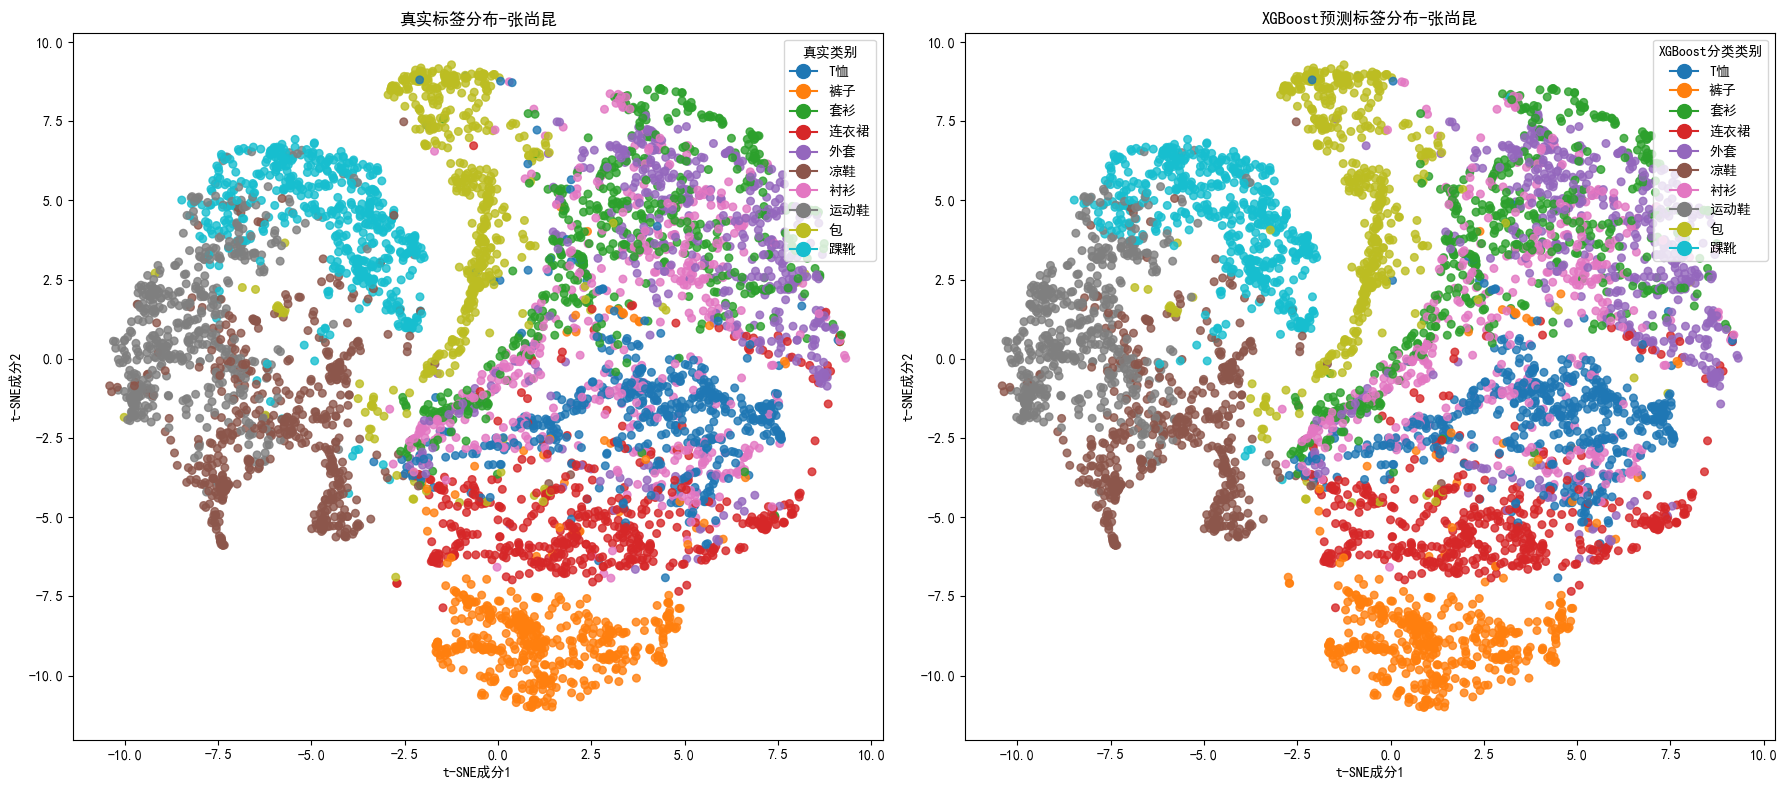

In [27]:
#XGBoost预测结果的t-SNE可视化
# 获取XGBoost的预测标签和概率
xgb_pred_labels = xgb.predict(latent_features_test)  # 预测标签
xgb_pred_probs = xgb.predict_proba(latent_features_test)  # 预测概率（形状：[样本数, 10]）

# 提取XGBoost的子集数据（与聚类子集保持一致的索引）
xgb_tsne_pred_labels = xgb_pred_labels[indices]  # 预测标签子集
xgb_tsne_true_labels = tsne_true_labels  # 真实标签子集（已抽样）
xgb_tsne_probs = xgb_pred_probs[indices]  # 预测概率子集

# 可视化2：XGBoost预测标签 vs. 真实标签（共用t-SNE坐标）
plt.figure(figsize=(18, 8))

# 子图1：按真实标签着色
plt.subplot(1, 2, 1)
scatter_true = plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], 
                          c=xgb_tsne_true_labels, cmap='tab10', s=30, alpha=0.8)
plt.title('真实标签分布-张尚昆')
plt.xlabel('t-SNE成分1')
plt.ylabel('t-SNE成分2')
# 手动创建图例，映射所有类别
legend_elements = [plt.Line2D([0], [0], marker='o', color=f'C{i}', label=class_names[i], markerfacecolor=f'C{i}', markersize=10) for i in range(10)]
plt.legend(handles=legend_elements, title="真实类别", loc='upper right')

# 子图2：按XGBoost预测标签着色
plt.subplot(1, 2, 2)
scatter_pred = plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], 
                          c=xgb_tsne_pred_labels, cmap='tab10', s=30, alpha=0.8)
plt.title('XGBoost预测标签分布-张尚昆')
plt.xlabel('t-SNE成分1')
plt.ylabel('t-SNE成分2')
# 手动创建图例，映射所有类别
legend_elements = [plt.Line2D([0], [0], marker='o', color=f'C{i}', label=class_names[i], markerfacecolor=f'C{i}', markersize=10) for i in range(10)]
plt.legend(handles=legend_elements, title="XGBoost分类类别", loc='upper right')

plt.tight_layout()

plt.show()




- 明显的可以看出，XBoost算法的效果会比聚类接近真实标签更多，综上对比，XGboost更适合作为分类方法来解决上述问题